#### Prologue

In [31]:
%run nursery_utils.py
%run nursery_dataprep.py

%matplotlib inline

Utility code in the associated file performs the following steps:
defines a custom summary function: rstr()
defines function to print pretty confusion matrix: plot_confusion_matrix()
defines a function to get the class code by label: get_class_code()
defines a function to plot a tree inline: tree_to_code()
defines a funciton to extract all the structural arrays of a tree: get_tree_structure()
defines a function to extract a metrics dictionary from a random forest: explore_forest()
defines a function to map the path of an instance down a tree: tree_path()
defines a function to map the path of an instance down a tree ensemble: forest_path()
defines a function to find the majority predicted class from object returned by forest_path(): major_class_from_forest_paths()
defines a function to convert a tree into a function: tree_to_code()

Utility code in the associated file performs the following steps:
set random seed
import packages and modules
create the list of variable names: var_names
c

# Data Description
Nursery Database was derived from a hierarchical decision model
originally developed to rank applications for nursery schools. It
was used during several years in 1980's when there was excessive
enrollment to these schools in Ljubljana, Slovenia, and the
rejected applications frequently needed an objective
explanation. The final decision depended on three subproblems:
occupation of parents and child's nursery, family structure and
financial standing, and social and health picture of the family.
The model was developed within expert system shell for decision
making DEX (M. Bohanec, V. Rajkovic: Expert system for decision
making. Sistemica 1(1), pp. 145-157, 1990.).

# Scenario
In this notebook, a decision tree and a random forest are built over the dataset and the results are explored with treeinterpreter

### Model Fitting and Scoring - One Decision Tree

In [32]:
# fit the model on the training set
dt = DecisionTreeClassifier(random_state=seed)
dt.fit(X_train_enc, y_train)

# helper function for prediction
enc_model = make_pipeline(encoder, dt)

pred = enc_model.predict(X_test)
print(metrics.cohen_kappa_score(y_test, pred))
cm = metrics.confusion_matrix(y_test, pred)

0.995106337247


### View Confusion Matrix

Confusion matrix, without normalization
[[1331    0    0    0    0]
 [   0 1249    0    5    0]
 [   0    0    1    0    0]
 [   0    6    0 1190    0]
 [   0    2    0    0  104]]
Normalized confusion matrix
[[ 1.          0.          0.          0.          0.        ]
 [ 0.          0.99601276  0.          0.00398724  0.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 0.          0.00501672  0.          0.99498328  0.        ]
 [ 0.          0.01886792  0.          0.          0.98113208]]


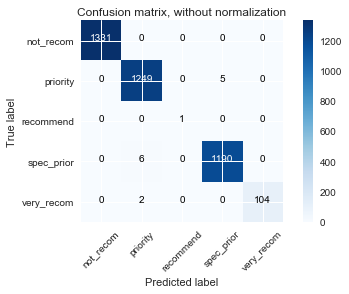

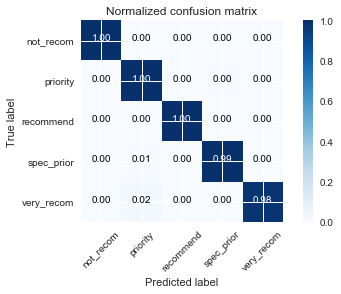

In [33]:
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm
                      , classes=class_names
                      , normalize=True,
                      title='Normalized confusion matrix')

In [34]:
# Collect useful data for instance
idx = 0
true_class = class_names[y_test[idx:idx + 1]]
pred_probs = enc_model.predict_proba(X_test[idx:idx + 1])[0]
# get the class codes produced by the model and the true class
true_class_code = get_class_code(true_class)

class_code_confs = np.argsort(pred_probs)[::-1] # descending order
pred_class_code = get_class_code(class_names[class_code_confs[0]])
second_class_code = get_class_code(class_names[class_code_confs[1]])

# Display instance row
nurs_id = X_test[idx:idx + 1].index[0]
nursery[nurs_id:nurs_id + 1]

C:\Dev\Prog\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


parents has_nurs    form children   housing     finance       social  \
854   usual   proper  foster     more  critical  convenient  problematic   

        health   decision  
854  not_recom  not_recom

In [35]:
interp_cols = class_names.tolist()
interp_cols.insert(0, 'predictor')
interp_cols.append('abseff')

for idx in [0, 10, 20]:
    prediction, bias, contributions = ti.predict(dt, encoder.transform(X_test[idx:idx + 1]))
    print("Classes", class_names)
    print("Bias (trainset prior)", bias)
    print("\n")
    print('Test instance id: %d' % idx)
    print('Pedicted Class Probabilities ')
    for c, p in zip(class_names, pred_probs):
        print(c, "{:0.4f}".format(p))
    print('True class: %s' % true_class)

    interp = pd.DataFrame(columns=interp_cols)
    # now extract contributions for each instance
    for c, feature in zip(contributions[0], onehot_features):
        if any(c != 0):
            vals = c.tolist()
            vals.insert(0, feature)
            vals.append(sum(abs(c)))
            interp = interp.append( dict(zip(interp_cols, vals))
                                   , ignore_index=True)
    interp = interp.sort_values('abseff', ascending=False).reset_index().drop('index', axis=1)
    print(interp)
    print("\n")

Classes ['not_recom' 'priority' 'recommend' 'spec_prior' 'very_recom']
Bias (trainset prior) [[  3.29475309e-01   3.32010582e-01   1.10229277e-04   3.13932981e-01
    2.44708995e-02]]


Test instance id: 0
Pedicted Class Probabilities 
not_recom 1.0000
priority 0.0000
recommend 0.0000
spec_prior 0.0000
very_recom 0.0000
True class: not_recom
          predictor  not_recom  priority  recommend  spec_prior  very_recom  \
0  health_not_recom   0.670525 -0.332011   -0.00011   -0.313933   -0.024471   

     abseff  
0  1.341049  


Classes ['not_recom' 'priority' 'recommend' 'spec_prior' 'very_recom']
Bias (trainset prior) [[  3.29475309e-01   3.32010582e-01   1.10229277e-04   3.13932981e-01
    2.44708995e-02]]


Test instance id: 10
Pedicted Class Probabilities 
not_recom 1.0000
priority 0.0000
recommend 0.0000
spec_prior 0.0000
very_recom 0.0000
True class: not_recom
            predictor  not_recom  priority  recommend  spec_prior  very_recom  \
0    health_not_recom  -0.329475  0.16314

### Create the tree plot

In [36]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data
                , class_names=class_names 
                , feature_names=onehot_features
                , filled=True, rounded=True
                , special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Repeat with RF

In [37]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, random_state=seed)
rf.fit(X_train_enc, y_train)

# helper function for prediction
enc_model = make_pipeline(encoder, rf)

pred = enc_model.predict(X_test)
print(metrics.cohen_kappa_score(y_test, pred))
cm = metrics.confusion_matrix(y_test, pred)

0.948482303799


### View Confusion Matrix

Confusion matrix, without normalization
[[1331    0    0    0    0]
 [   0 1190    0   64    0]
 [   0    0    0    0    1]
 [   0   10    0 1186    0]
 [   0   61    0    0   45]]
Normalized confusion matrix
[[ 1.          0.          0.          0.          0.        ]
 [ 0.          0.94896332  0.          0.05103668  0.        ]
 [ 0.          0.          0.          0.          1.        ]
 [ 0.          0.0083612   0.          0.9916388   0.        ]
 [ 0.          0.5754717   0.          0.          0.4245283 ]]


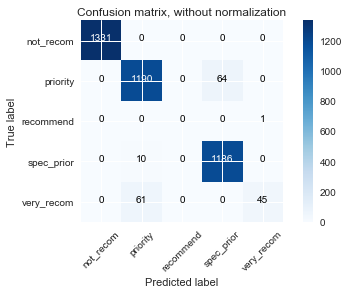

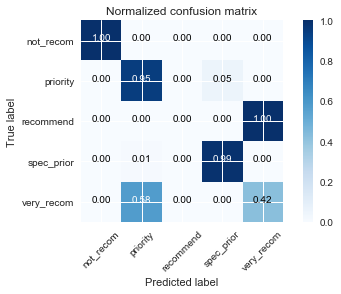

In [38]:
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm
                      , classes=class_names
                      , normalize=True,
                      title='Normalized confusion matrix')

In [39]:
interp_cols = class_names.tolist()
interp_cols.insert(0, 'predictor')
interp_cols.append('abseff')

print("Classes", class_names)
print("Bias (trainset prior)", bias)

for idx in [0, 10, 20]:
    prediction, bias, contributions = ti.predict(rf, encoder.transform(X_test[idx:idx + 1]))
    print("\n")
    print('Test instance id: %d' % idx)
    print('Pedicted Class Probabilities ')
    for c, p in zip(class_names, pred_probs):
        print(c, "{:0.4f}".format(p))
    print('True class: %s' % true_class)

    interp = pd.DataFrame(columns=interp_cols)
    # now extract contributions for each instance
    for c, feature in zip(contributions[0], onehot_features):
        if any(c != 0):
            vals = c.tolist()
            vals.insert(0, feature)
            vals.append(sum(abs(c)))
            interp = interp.append( dict(zip(interp_cols, vals))
                                   , ignore_index=True)
    interp = interp.sort_values('abseff', ascending=False).reset_index().drop('index', axis=1)
    print(interp)
    print("\n")

Classes ['not_recom' 'priority' 'recommend' 'spec_prior' 'very_recom']
Bias (trainset prior) [[  3.29475309e-01   3.32010582e-01   1.10229277e-04   3.13932981e-01
    2.44708995e-02]]


Test instance id: 0
Pedicted Class Probabilities 
not_recom 1.0000
priority 0.0000
recommend 0.0000
spec_prior 0.0000
very_recom 0.0000
True class: not_recom
               predictor  not_recom      priority     recommend  spec_prior  \
0       health_not_recom   0.413646 -2.549904e-01 -1.334458e-04   -0.143006   
1     health_recommended   0.137682 -9.508136e-02 -1.001057e-04   -0.029492   
2        health_priority   0.108369 -5.928371e-02  3.203032e-05   -0.053590   
3        has_nurs_proper  -0.001652  4.140618e-02  9.915884e-05   -0.044802   
4     parents_great_pret   0.000332  1.801367e-02  1.361053e-05   -0.020821   
5     has_nurs_very_crit  -0.000020  1.897707e-02  7.996294e-06   -0.020558   
6          parents_usual   0.001117  1.419196e-02  4.685512e-05   -0.017709   
7      has_nurs_critical

### Exploring the model

In [40]:
print("Training set priors:")
y_train.value_counts(sort=False)/len(y_train)

Training set priors:


0    0.329475
1    0.332011
2    0.000110
3    0.313933
4    0.024471
Name: decision, dtype: float64

In [41]:
print("RF model biases:")
print(pd.Series(bias[0]))
# not exactly the same as for a single decision tree. Presume aggregate measure from multiple bootstraps?

RF model biases:
0    0.329268
1    0.332296
2    0.000109
3    0.313947
4    0.024380
dtype: float64


### Create a tree plot for single tree

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.568427 to fit



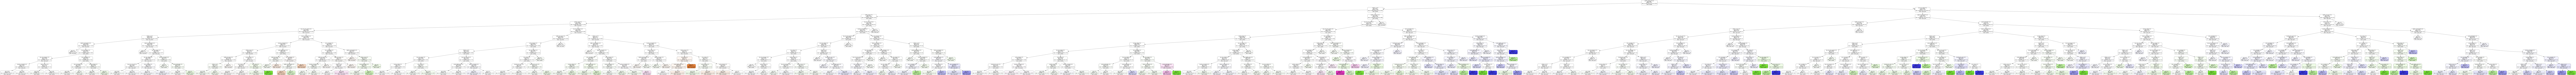

In [42]:
# one tree
rft = rf.estimators_[0]
dot_data = StringIO()
export_graphviz(rft, out_file=dot_data
                , class_names=class_names
                , feature_names=onehot_features
                , filled=True, rounded=True
                , special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [43]:
# to examine one tree
n_nodes = rft.tree_.node_count
children_left = rft.tree_.children_left
children_right = rft.tree_.children_right
feature = rft.tree_.feature
threshold = rft.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if %s <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 onehot_features[feature[i]],
                 threshold[i],
                 children_right[i],
                 ))
print()



The binary tree structure has 607 nodes and has the following tree structure:
node=0 test node: go to node 1 if parents_great_pret <= 0.5 else to node 334.
	node=1 test node: go to node 2 if children_1 <= 0.5 else to node 207.
		node=2 test node: go to node 3 if health_priority <= 0.5 else to node 148.
			node=3 test node: go to node 4 if parents_usual <= 0.5 else to node 81.
				node=4 test node: go to node 5 if has_nurs_less_proper <= 0.5 else to node 38.
					node=5 test node: go to node 6 if children_3 <= 0.5 else to node 23.
						node=6 test node: go to node 7 if health_recommended <= 0.5 else to node 8.
							node=7 leaf node.
							node=8 test node: go to node 9 if has_nurs_proper <= 0.5 else to node 16.
								node=9 test node: go to node 10 if has_nurs_improper <= 0.5 else to node 13.
									node=10 test node: go to node 11 if housing_convenient <= 0.5 else to node 12.
										node=11 leaf node.
										node=12 leaf node.
									node=13 test node: go to node 14 if 

In [44]:
# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = rft.decision_path(encoder.transform(X_test))

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = rft.apply(encoder.transform(X_test))

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]


# print(node_indicator)
# print(leave_id)
# print(node_index)

# print('Rules used to predict sample %s: ' % sample_id)

In [45]:
print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] != node_id:
        continue
    if feature[node_id] < 0:
        continue
    if (X_test[features[feature[node_id]]][sample_id:sample_id + 1] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

Rules used to predict sample 0: 

The following samples [0, 1] share the node [0 1] in the tree
It is 0.32948929159802304 % of all nodes.
